In [502]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

In [503]:
def ranking_precision_score(y_true, y_score, k=10):
    """Precision at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    Returns
    -------
    precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) == 2:
        pos_label = unique_y[1]
        n_pos = np.sum(y_true == pos_label)

        order = np.argsort(y_score)[::-1]
        y_true = np.take(y_true, order[:k])
        n_relevant = np.sum(y_true == pos_label)

        # Divide by min(n_pos, k) such that the best achievable score is always 1.0.
        return float(n_relevant) / min(n_pos, k)
    else:
        return -1
def rank_precision(data_frame,k=4): # passed to groupby object 
    y_true=list(data_frame[1])
    y_score=list(data_frame[2])
    return ranking_precision_score(y_true, y_score, k=k)

In [504]:
class Model:
    def __init__(self,name="GBDT",alpha=0,penalty=0,topk=-1,attrN=-1,preds=None):
        self.name=name
        self.pen=penalty
        self.topk=topk
        self.preds=preds
        self.attrN=attrN
        self.alpha=alpha
        
    def get_AUC(self):
        return roc_auc_score(trueY,self.preds) if self.preds is not None else None
    
    #add some other metrics later
    
    def get_ranking_precision(self,k=2): # ranking_precision_score averaged over queries
        combined=pd.concat([kw,trueY,self.preds],axis=1,ignore_index=True)
        grouped=combined.groupby(combined[0])
        agged=grouped.apply(rank_precision)
        agged=[num for num in agged if num>=0]
        return sum(agged)/(len(agged)) if len(agged)>0 else 0
        
        
        
        
        

In [505]:
###### result files paths

# result_path='result_test_us_mod_sub/'
# aux_path='aux_result_test_us_mod_sub/'
# attr_total=174

result_path='result/gold_in_qa_split/'
attr_total=96


# result_path='synthetic/result_syn1_test/'
# aux_path='synthetic/aux_result_syn1_test/'
# attr_total=100



In [506]:
## preprocess

filenames_result=listdir(result_path)
trueY=pd.read_csv(result_path+"trueY.txt",header=None)[0]
kw=pd.read_csv(result_path+"keyword.txt",header=None)[0]
try:
    number_unused=len(pd.read_csv(result_path+"preprocess_unused.txt",header=None))
except:
    number_unused=0
attr_init_number=attr_total-number_unused

In [507]:
attr_init_number

67

In [508]:
import collections

In [509]:
# store results when go through all files in result folder
# index result like [(mu,alpha)]
GBFS_dict=collections.defaultdict(dict) # store preds,attrN for different mu and alpha
GBDTt_dict={} # indexed by alpha,topk
for filename in filenames_result:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt" and "_alpha" in fname:
        alpha=float(fname[fname.index("_alpha")+6:])
        if "_preds" in fname:
            preds=pd.read_csv(result_path+filename,header=None)[0]
            if "GBFSt" in fname:
                attrN=int(fname[5:fname.index("_mu")])
                GBDTt_dict[alpha,attrN]=preds
            else:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:fname.index("_preds")])
                GBFS_dict[mu,alpha]["preds"]=preds
        elif "feature_scores_" in fname:
            tmp=pd.read_csv(result_path+filename,header=None)[0][0] # the first line of feature_score reports attrN
            attrN=int(tmp.split()[-1])
            if "_mu" in fname:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:fname.index("_alpha")])
            else:
                mu=0
            GBFS_dict[mu,alpha]["attrN"]=attrN
            

In [510]:
# put result together
model_results=collections.defaultdict(list) # indexed by mu,alpha
# GBFS model
for mu,alpha in GBFS_dict:
    try:
        attrN=GBFS_dict[mu,alpha]["attrN"]
        preds=GBFS_dict[mu,alpha]["preds"]
        model_results[mu,alpha].append(Model(penalty=mu,alpha=alpha,topk=-1,attrN=attrN,preds=preds))
    except:
        print("not ready")
# GBDTt model
for alpha,topk in GBDTt_dict:
    preds=GBDTt_dict[alpha,topk]
    model_results[0,alpha].append(Model(alpha=alpha,topk=topk,attrN=topk,preds=preds))
    
    
    
    

not ready


In [511]:
## plots
import matplotlib.pyplot as plt

In [512]:
mus=sorted(set(idx[0] for idx in GBFS_dict.keys()))

In [513]:
alphas=sorted(set(idx[1] for idx in GBFS_dict.keys()))

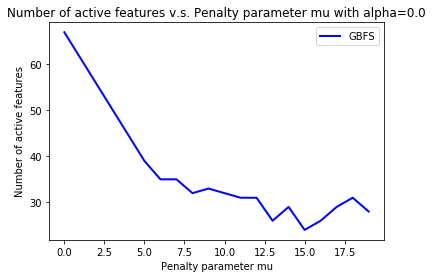

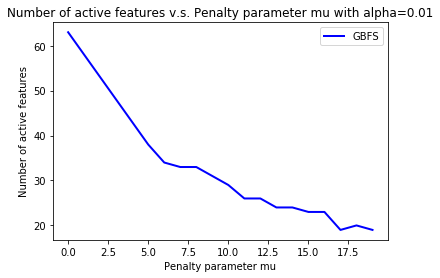

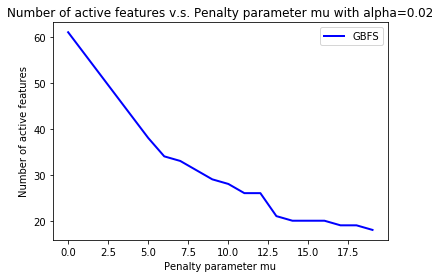

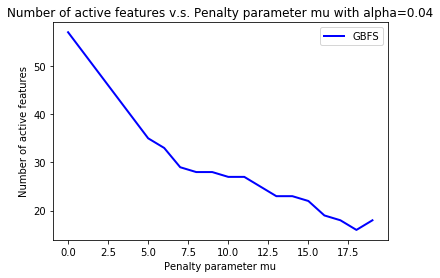

KeyError: 'attrN'

<Figure size 432x288 with 0 Axes>

In [514]:
# plot1 attrN v.s. mus for GBFS
for alpha in alphas:
    plt.figure()
    lw = 2
    x_axis=mus
    y_axis=[GBFS_dict[mu,alpha]["attrN"] for mu in x_axis]
    plt.plot(x_axis, y_axis, color='b',
             lw=lw, label='GBFS')
    #plt.xlim([0.0, max(x_axis)])
    #plt.ylim([20, 100])
    plt.xlabel('Penalty parameter mu')
    plt.ylabel('Number of active features')
    plt.title(f'Number of active features v.s. Penalty parameter mu with alpha={alpha}')
    plt.legend(loc="upper right")
    plt.show()

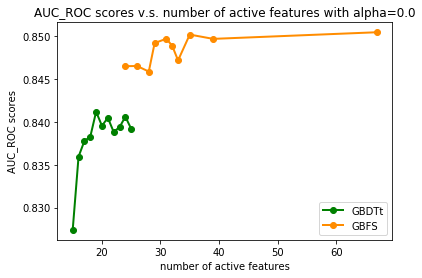

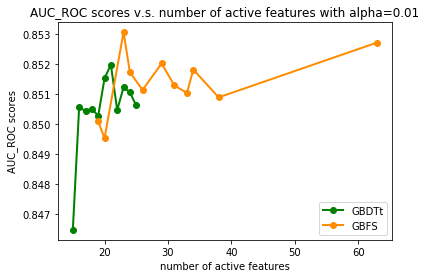

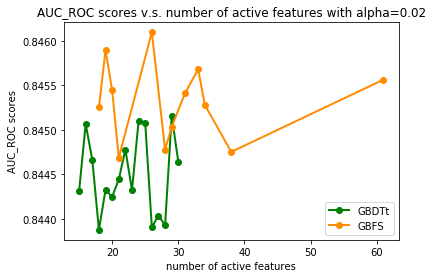

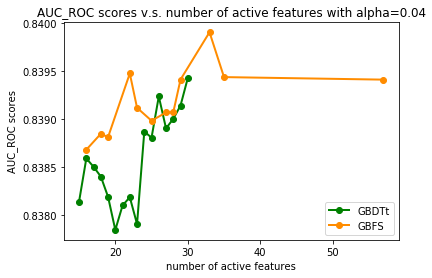

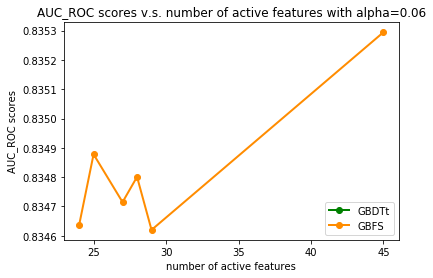

In [516]:
# plot2 AUC_ROC v.s. attrN (for best score with the given attrN for GBFS) given alpha

GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.pen==0 and model.topk>0:
            GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_AUC())
        elif model.topk==-1: 
            GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_AUC())
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y1_axis=[GBDTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y2_axis=[GBFS[x,alpha] for x in x2_axis]
    plt.plot(x1_axis, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    #plt.ylim([0.93, 0.95])
    plt.xlabel('number of active features')
    plt.ylabel('AUC_ROC scores')
    plt.title(f'AUC_ROC scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()

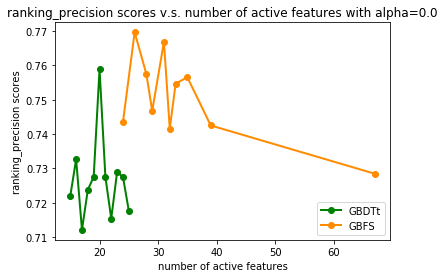

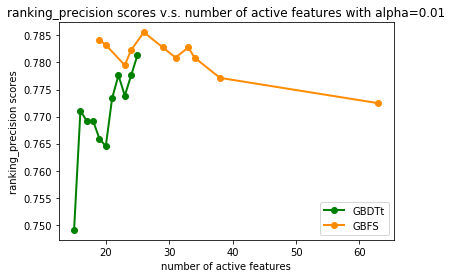

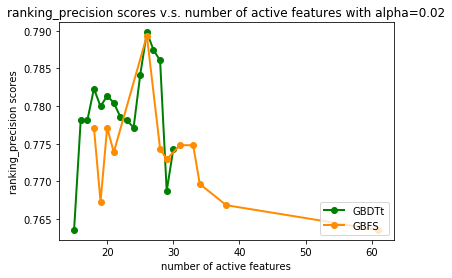

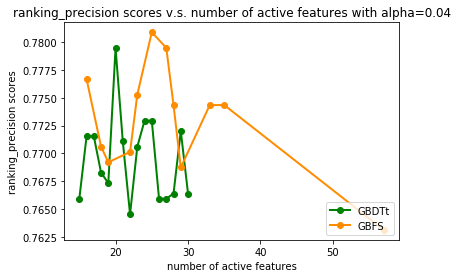

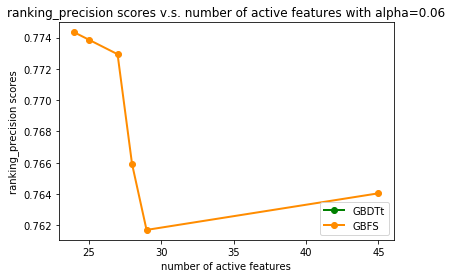

In [515]:
# plot3 precision @2 v.s. attrN (for best score with the given attrN for GBFS) given alpha

GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.pen==0 and model.topk>0:
            GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_ranking_precision())
        elif model.topk==-1: 
            GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_ranking_precision())
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y1_axis=[GBDTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y2_axis=[GBFS[x,alpha] for x in x2_axis]

    plt.plot(x1_axis, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    #plt.ylim([0.93, 0.95])
    plt.xlabel('number of active features')
    plt.ylabel('ranking_precision scores')
    plt.title(f'ranking_precision scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()